# Checking our implementation of MoM-based regression with the one provided by Lecué and Lerasle

The goal of this notebook is to compare our algorithm with the one provided by Lecué and Lerasle (LL) in their implementation of the Median of Means (avaliable at https://github.com/lecueguillaume/MOMpower). This is a simple check to see if our code and theirs present the same behavior.
We start importing a few libraries and functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import json
import itertools

from src.plot import *
from src.fit import fit_by_admm, MOMBlockGenerator, fit_by_plugin, fit_by_admm
from src.data import generate_dataset

## Can we reproduce the same behavior observed in LL article?

Here, we compare our implementation with the ADMM-MOM implementation given by LL (https://github.com/lecueguillaume/MOMpower) in the following procedure:
- We use their code to generate data and to fit the data;
- Using the same data we use our code to fit the data;
- We compare both implementations (theirs = solid lines; ours = dotted lines);

**Notice that curves will not match perfectly since both algorithms are non-deterministic.**

In [4]:
### MOM CODE

def median_index(vector):
    med = np.median(vector)
    return np.nanargmin(np.abs(vector-med))

def random_block(X, y, x, x_prime, K):
    vect_means = []
    N = y.size
    li = np.arange(N)
    np.random.shuffle(li)
    for k in np.arange(0, K):
        ind = li[k*int(N/K): (k+1)*int(N/K)]
        Xk, yk = X[ind], y[ind]
        excess_loss_k = np.linalg.norm(Xk.dot(x) - yk) ** 2 - np.linalg.norm(Xk.dot(x_prime) - yk) ** 2
        vect_means.append(excess_loss_k)
    idx_med = median_index(vect_means)
    ind = li[idx_med*int(N/K): (idx_med+1)*int(N/K)]
    #print(idx_med)
    return X[ind], y[ind], ind

def beta_func(n_features, sparsity):
    idx = np.arange(n_features)
    beta = (n_features/10)*(-1) ** (abs(idx - 1)) * np.exp(-idx / 10.)
    sel = np.random.permutation(n_features)
    sel1 = sel[0:int(sparsity/4)]
    beta[sel1] = 10
    sel11 = sel[int(sparsity/4):int(sparsity/2)]
    beta[sel11] = -10
    sel0 = sel[sparsity:]
    beta[sel0] = 0.
    return beta

def soft_threshod(w, mu):
    return np.multiply(np.sign(w), np.maximum(np.abs(w)- mu,0))  

## Define the objective function for MOM 
def mom_obj(X, y, x, x_prime, lamda):
    r = X*x - y
    r_prime = X*x_prime - y
    return np.sum(np.multiply(r,r))/2 +  lamda * np.sum(np.abs(x)) - np.sum(np.multiply(r_prime,r_prime))/2 +  lamda * np.sum(np.abs(x_prime))

def data1(n_samples, beta, sigma):
    n_features = beta.size
    cov = np.identity(n_features)
    X = np.random.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    Y = X.dot(beta) + sigma * np.random.randn(n_samples)
    return Y, X

def block(X, y, x, x_prime, K):
    vect_means = []
    N = y.size
    for k in np.arange(0,K):
        Xk, yk = X[k*int(N/K):(k+1)*int(N/K)], y[k*int(N/K):(k+1)*int(N/K)]
        excess_loss_k = np.linalg.norm(Xk.dot(x) - yk) ** 2 - np.linalg.norm(Xk.dot(x_prime) - yk) ** 2
        vect_means.append(excess_loss_k)
    idx_med = median_index(vect_means)
    #print(idx_med)
    return X[idx_med*int(N/K):(idx_med+1)*int(N/K)], y[idx_med*int(N/K):(idx_med+1)*int(N/K)]

## MOM ADMM
def MOM_ADMM(X, y, beta_0, K=3, max_iter=100, lamda = 1):
    dim = X.shape[1]
    x, x_prime = np.matrix([0.0]*dim).T, np.matrix([0.0]*dim).T
    z, z_prime = x, x_prime
    u, u_prime = x, x_prime
    mom_obj_ADMM, mom_error_ADMM = [], []
    rho = 5
    #print("Lauching MOM-ADMM solver...")
    for t in range(0, max_iter):
        #if (t%100==0):
        #    print('iter= {}, estimation error MOM ADMM = {:3f}'.format(t, norm(beta_0 - x)))
        #descent
        Xk, yk = block(X, y, x, x_prime, K)
        x = np.linalg.solve((Xk.T)*Xk + rho*np.identity(dim), Xk.T*yk + rho*z - u)
        z = soft_threshod(x + u/rho, lamda/rho)
        u = u + rho * (x-z)
        #ascent
        Xk, yk = block(X, y, x, x_prime, K)
        x_prime = np.linalg.solve((Xk.T)*Xk + rho*np.identity(dim), Xk.T*yk + rho*z_prime - u_prime)
        z_prime = soft_threshod(x_prime + u_prime/rho, lamda/rho)
        u_prime = u_prime + rho * (x_prime-z_prime)

        mom_obj_ADMM.append(mom_obj(X, y, x, x_prime, lamda))
        mom_error_ADMM.append(np.linalg.norm(beta_0 - x))
    return mom_error_ADMM, mom_obj_ADMM, x

## MOM ADMM RANDOM BLOCKS
def MOM_ADMM_RANDOM_BLOCKS(X, y, beta_0, K=3, max_iter=100, lamda = 1):
    dim = X.shape[1]
    x, x_prime = np.matrix([0.0]*dim).T, np.matrix([0.0]*dim).T
    z, z_prime = x, x_prime
    u, u_prime = x, x_prime
    mom_obj_ADMM, mom_error_ADMM = [], []
    rho = 5
    list_ind_selected = []
    # print("Lauching MOM-ADMM-RANDOM-BLOCKS solver...")
    for t in range(0, max_iter):
        # if (t%100==0):
        #     print('iter= {}, estimation error MOM ADMM RANDOM BLOCKS = {:3f}'.format(t, np.linalg.norm(beta_0 - x)))
        #descent
        Xk, yk, ind = random_block(X, y, x, x_prime, K)
        x = np.linalg.solve((Xk.T)*Xk + rho*np.identity(dim), Xk.T*yk + rho*z - u)
        z = soft_threshod(x + u/rho, lamda/rho)
        u = u + rho * (x-z)
        list_ind_selected.append(ind)
        #ascent
        Xk, yk, ind = random_block(X, y, x, x_prime, K)
        x_prime = np.linalg.solve((Xk.T)*Xk + rho*np.identity(dim), Xk.T*yk + rho*z_prime - u_prime)
        z_prime = soft_threshod(x_prime + u_prime/rho, lamda/rho)
        u_prime = u_prime + rho * (x_prime-z_prime)
        list_ind_selected.append(ind)

        mom_obj_ADMM.append(mom_obj(X, y, x, x_prime, lamda))
        mom_error_ADMM.append(np.linalg.norm(beta_0 - x))
    
    return mom_error_ADMM, mom_obj_ADMM, x, list_ind_selected

  0%|          | 0/9 [00:00<?, ?it/s]

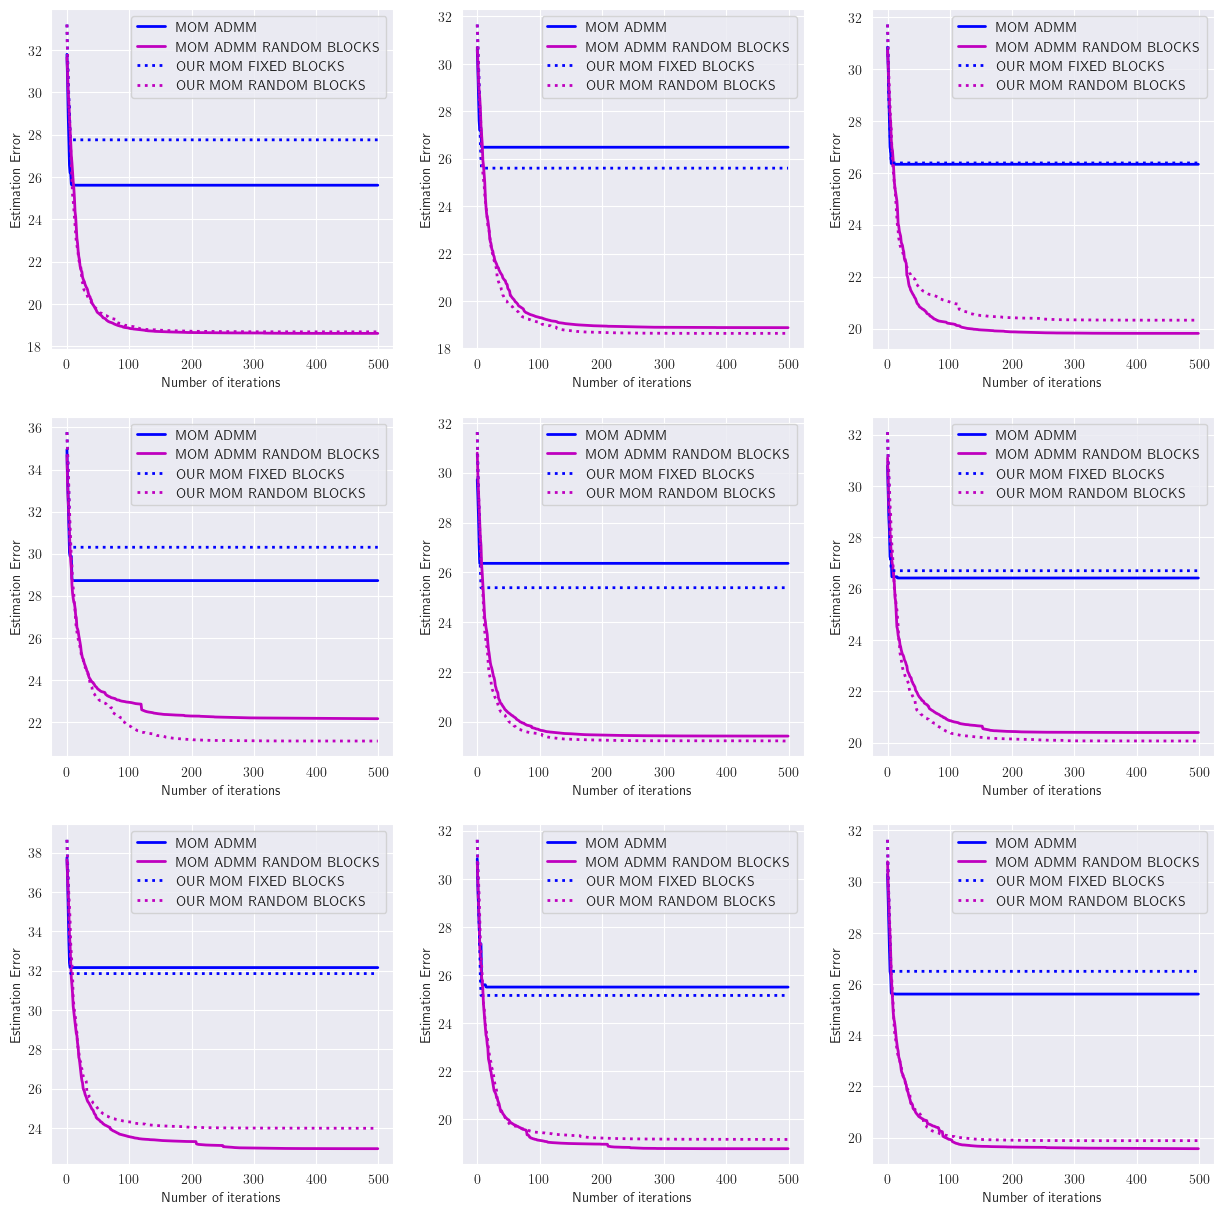

In [14]:
plt.figure(figsize = (15, 15))
for seed in tqdm(range(1, 10)):
    np.random.seed(seed)
    n_features, sparsity = 300, 20
    beta_0 = beta_func(n_features, sparsity)
    n_samples,  sigma = 200, 1
    y, X = data1(n_samples, beta_0,  sigma)
    beta_0 = np.matrix(beta_0).T
    y = np.matrix(y).T
    X = np.matrix(X)
    K, max_iter, lamda = 10, 500, 0 # lambda must be 0 since our method is for non sparse data
    
    mom_error_ADMM, _, _ = MOM_ADMM(X, y,beta_0, K, max_iter, lamda)
    mom_error_ADMM_random_blocks, _, _, _ = MOM_ADMM_RANDOM_BLOCKS(X, y,beta_0, K, max_iter, lamda)

    beta_history, cost_history = fit_by_admm(
        np.array(X),
        np.array(y)[:,0],
        np.zeros(n_features),
        np.zeros(n_features),
        K,
        method = "MOM",
        max_iter = max_iter,
        block_generator = MOMBlockGenerator("fixed", np.random.default_rng(seed), n_samples, K)
    )
    beta_0 = np.array(beta_0)[:,0]
    L2_MOM_fixed = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
    beta_history, cost_history = fit_by_admm(
        np.array(X),
        np.array(y)[:,0],
        np.zeros(n_features),
        np.zeros(n_features),
        K,
        method = "MOM",
        max_iter = max_iter,
        block_generator = MOMBlockGenerator("random", np.random.default_rng(seed), n_samples, K)
    )
    L2_MOM_random = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]

    t = np.arange(0, max_iter)
    plt.subplot(3,3,seed)
    plt.plot(t, np.array(mom_error_ADMM), 'b', linewidth = 2, label = 'MOM ADMM')
    plt.plot(t, np.array(mom_error_ADMM_random_blocks), 'm', linewidth = 2, label = 'MOM ADMM RANDOM BLOCKS')
    plt.plot(t, np.array(L2_MOM_fixed), 'b', ls=":", linewidth = 2, label = 'OUR MOM FIXED BLOCKS')
    plt.plot(t, np.array(L2_MOM_random), 'm', ls=":", linewidth = 2, label = 'OUR MOM RANDOM BLOCKS')
    plt.legend(loc=1)
    plt.xlabel('Number of iterations')
    plt.ylabel('Estimation Error')

plt.show()

### Non-sparse data with $p < n$

All experiments in LL are with sparse data. The previous experiment used $p = 300$ and $n = 200$, but only $20$ of the $p$ entries were non-zero. We now let $p=20$ and $n=200$ with no sparsity.

  0%|          | 0/9 [00:00<?, ?it/s]

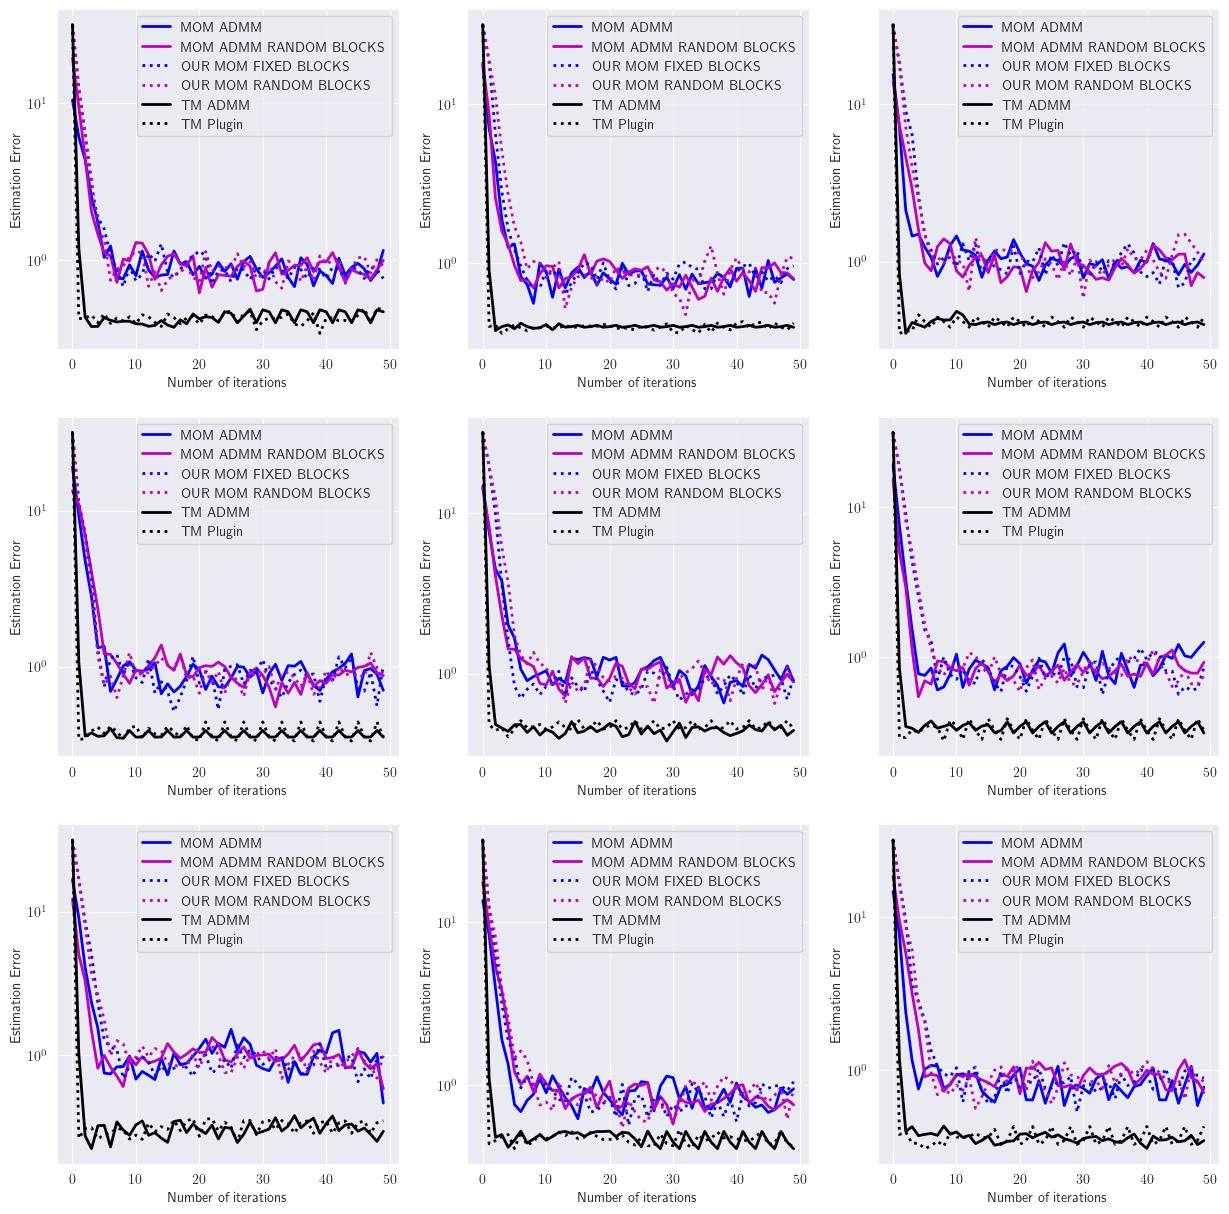

In [10]:
plt.figure(figsize = (15, 15))
for seed in tqdm(range(1, 10)):
    np.random.seed(seed)
    n_features, sparsity = 20, 20
    beta_0 = beta_func(n_features, sparsity)
    n_samples, sigma = 200, 1
    y, X = data1(n_samples, beta_0,  sigma)
    beta_0 = np.matrix(beta_0).T
    y = np.matrix(y).T
    X = np.matrix(X)
    K, max_iter, lamda = 10, 50, 0 # lambda must be 0 since our method is for non sparse data

    mom_error_ADMM, _, _ = MOM_ADMM(X, y,beta_0, K, max_iter, lamda)
    mom_error_ADMM_random_blocks, _, _, _ = MOM_ADMM_RANDOM_BLOCKS(X, y,beta_0, K, max_iter, lamda)

    beta_history, cost_history = fit_by_admm(
        np.array(X),
        np.array(y)[:,0],
        np.zeros(n_features),
        np.zeros(n_features),
        K,
        method = "MOM",
        max_iter = max_iter,
        block_generator = MOMBlockGenerator("fixed", np.random.default_rng(seed), n_samples, K)
    )
    beta_0 = np.array(beta_0)[:,0]
    L2_MOM_fixed = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
    beta_history, cost_history = fit_by_admm(
        np.array(X),
        np.array(y)[:,0],
        np.zeros(n_features),
        np.zeros(n_features),
        K,
        method = "MOM",
        max_iter = max_iter,
        block_generator = MOMBlockGenerator("random", np.random.default_rng(seed), n_samples, K)
    )
    L2_MOM_random = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
    beta_history, cost_history = fit_by_admm(
        np.array(X),
        np.array(y)[:,0],
        np.zeros(n_features),
        np.zeros(n_features),
        5,
        method = "TM",
        max_iter = max_iter
    )
    L2_TM_ADMM = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
    beta_history, cost_history = fit_by_plugin(
        np.array(X),
        np.array(y)[:,0],
        np.zeros(n_features),
        np.zeros(n_features),
        5,
        method = "TM",
        max_iter = max_iter - 1
    )
    L2_TM_PLUGIN = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]

    t = np.arange(0, max_iter)
    plt.subplot(3,3,seed)
    plt.plot(t, np.array(mom_error_ADMM), 'b', linewidth = 2, label = 'MOM ADMM')
    plt.plot(t, np.array(mom_error_ADMM_random_blocks), 'm', linewidth = 2, label = 'MOM ADMM RANDOM BLOCKS')
    plt.plot(t, np.array(L2_MOM_fixed), 'b', ls=":", linewidth = 2, label = 'OUR MOM FIXED BLOCKS')
    plt.plot(t, np.array(L2_MOM_random), 'm', ls=":", linewidth = 2, label = 'OUR MOM RANDOM BLOCKS')
    plt.plot(t, np.array(L2_TM_ADMM), 'black', linewidth = 2, label = 'TM ADMM')
    plt.plot(t, np.array(L2_TM_PLUGIN), 'black', ls=":", linewidth = 2, label = 'TM Plugin')
    plt.legend(loc=1)
    plt.xlabel('Number of iterations')
    plt.ylabel('Estimation Error')
    plt.yscale("log")

plt.show()

### We now add contamination using our data generation process

  0%|          | 0/9 [00:00<?, ?it/s]

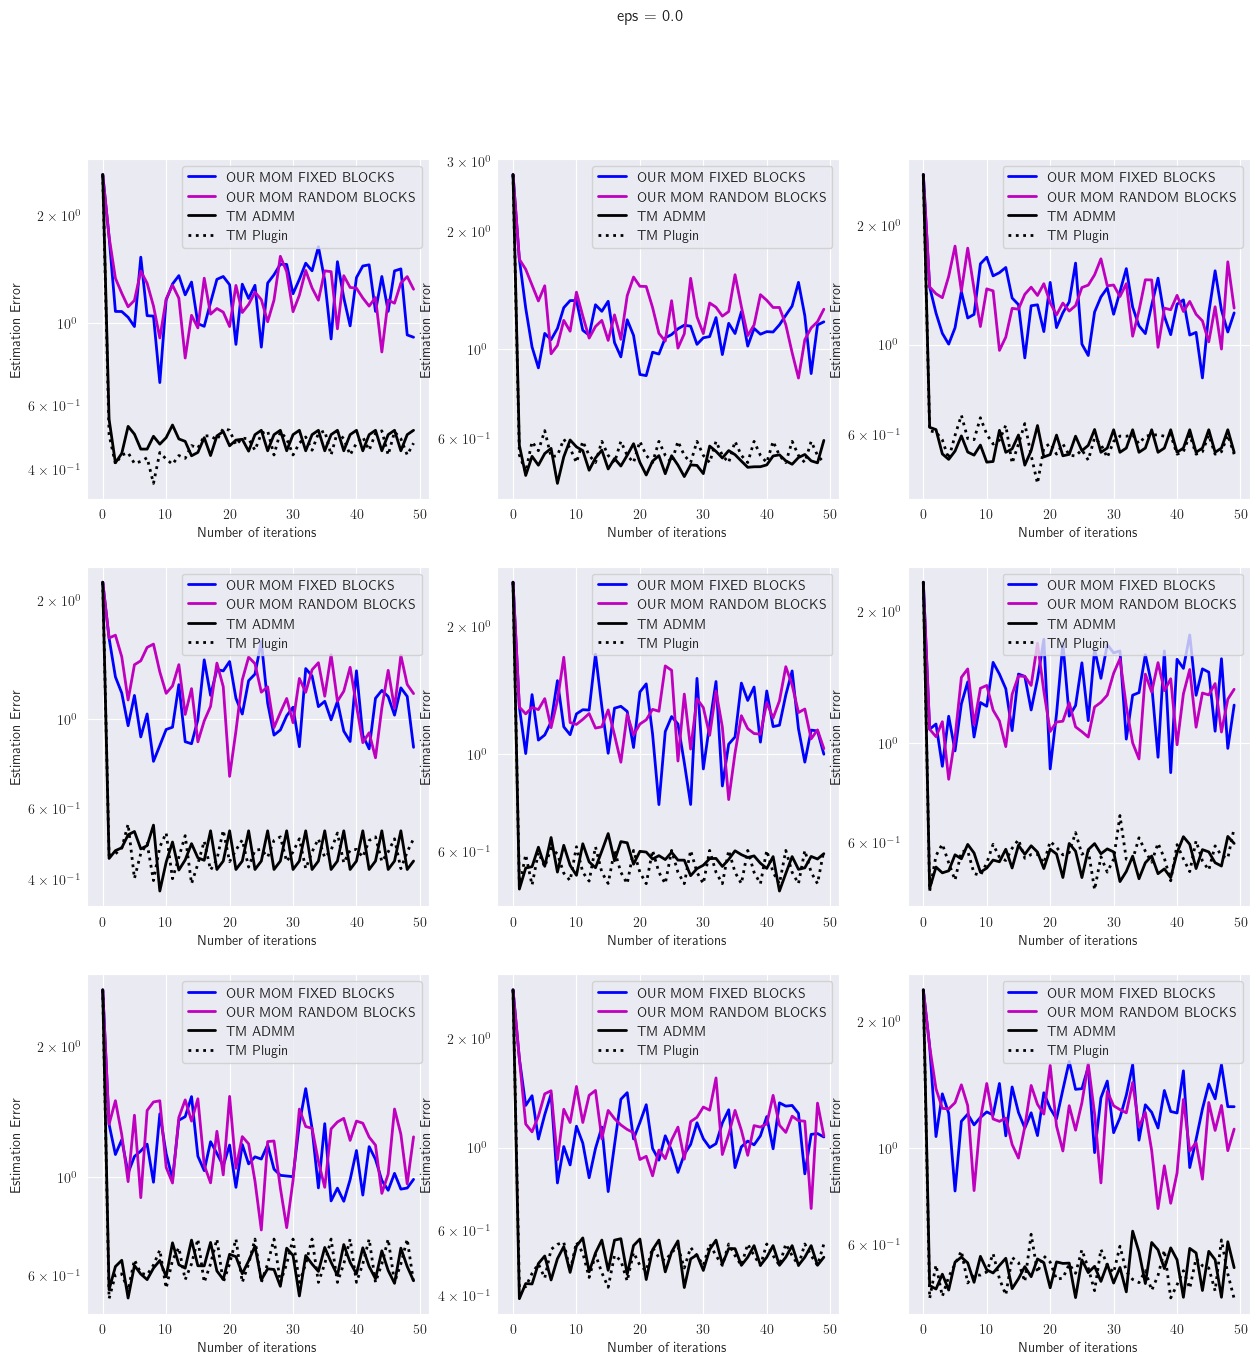

  0%|          | 0/9 [00:00<?, ?it/s]

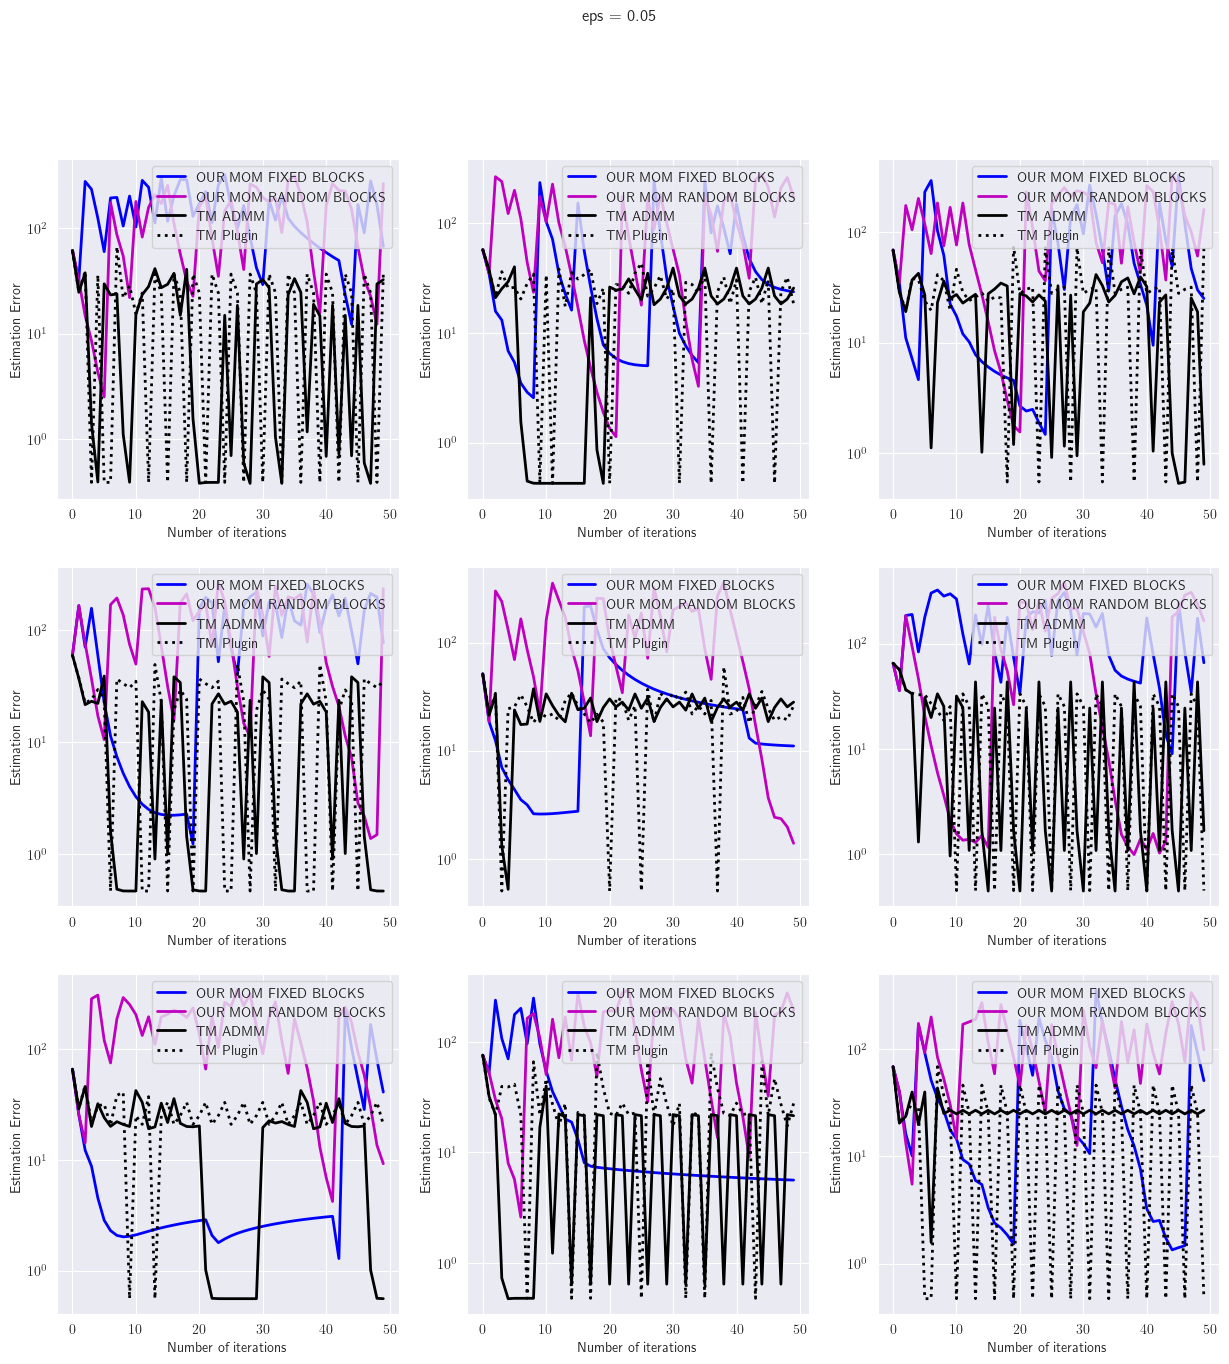

  0%|          | 0/9 [00:00<?, ?it/s]

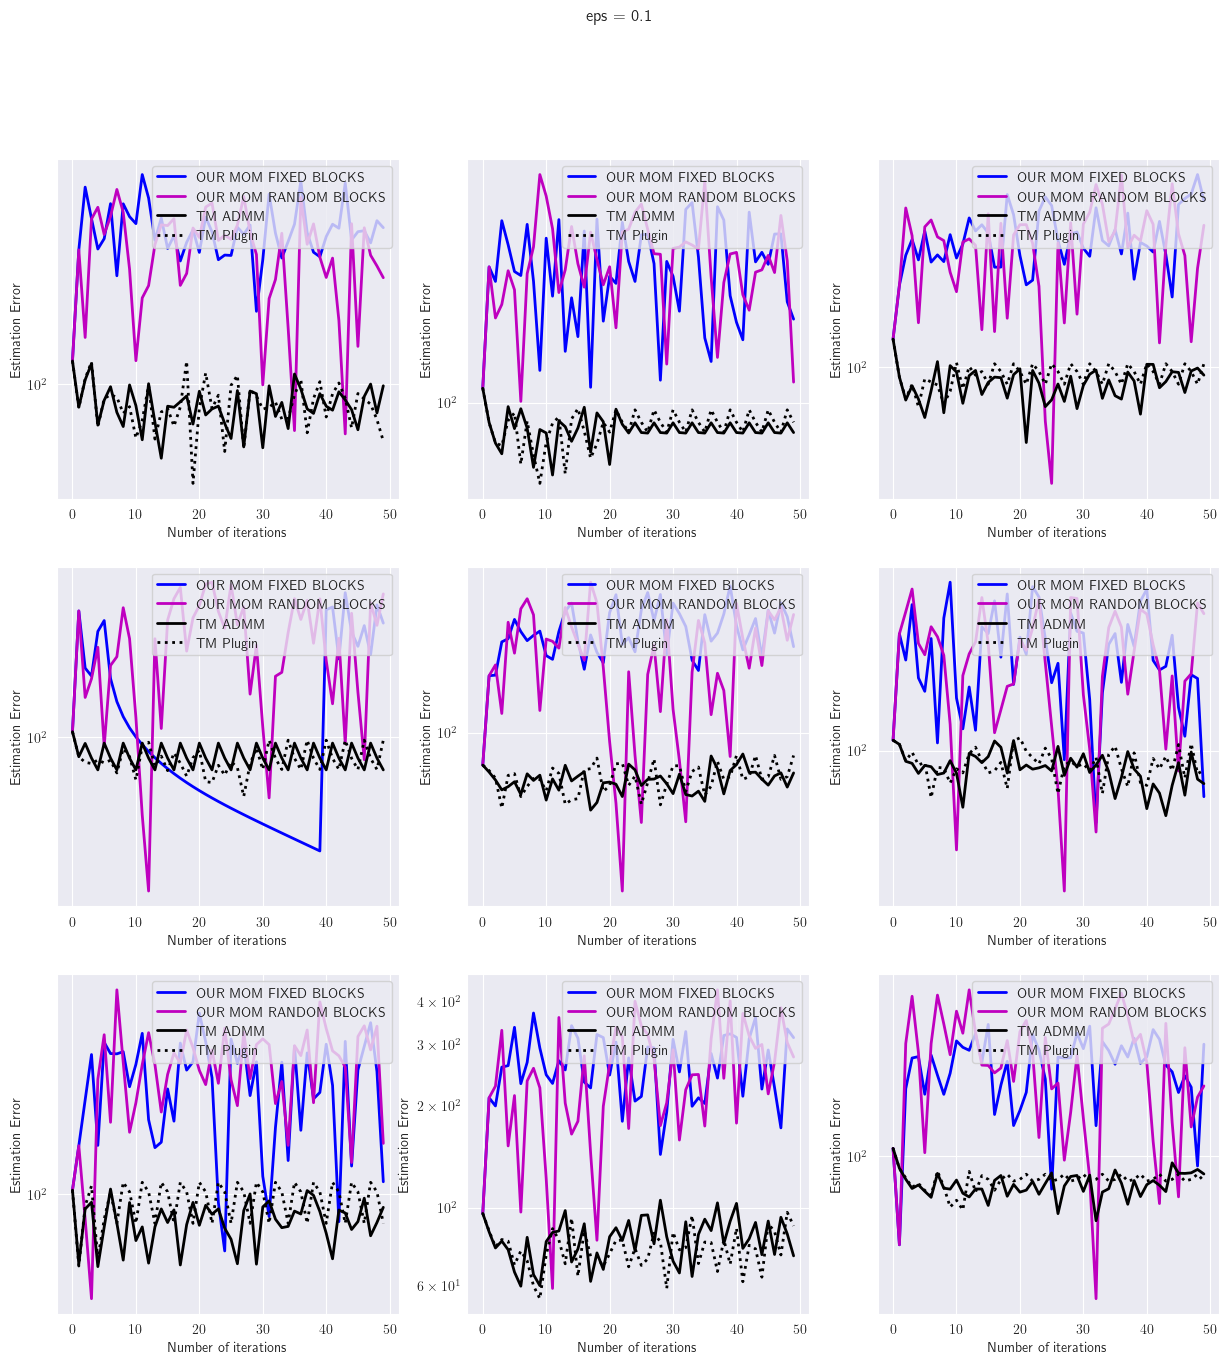

  0%|          | 0/9 [00:00<?, ?it/s]

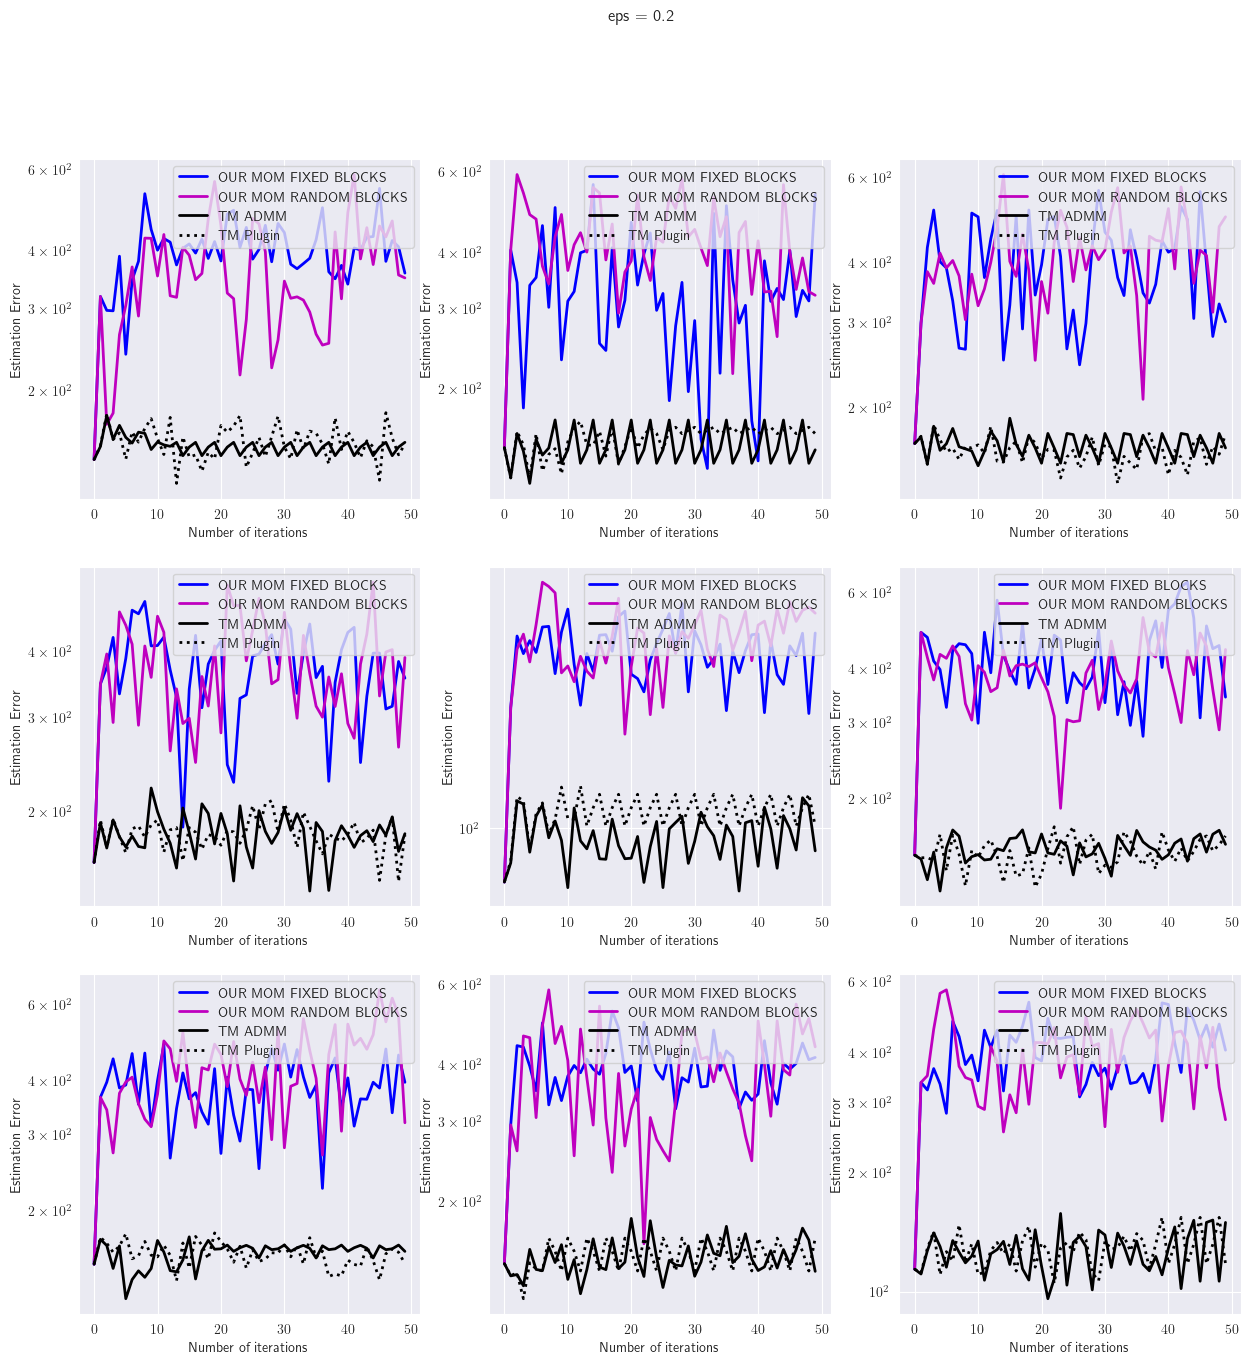

  0%|          | 0/9 [00:00<?, ?it/s]

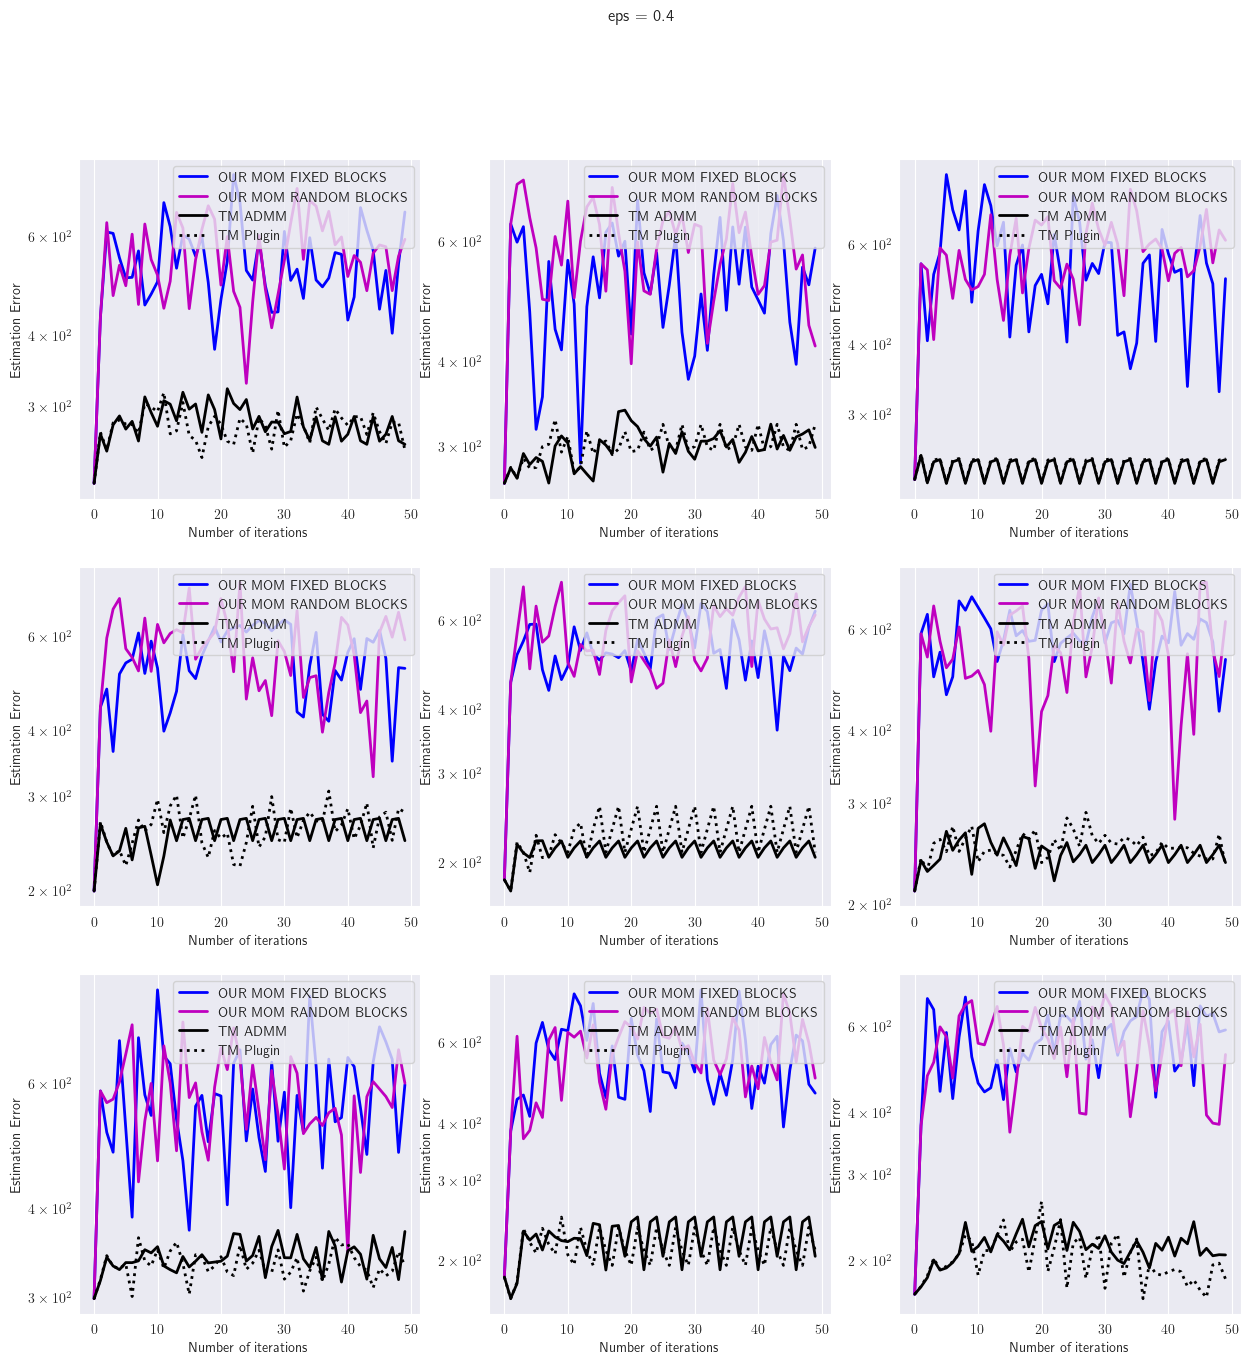

In [13]:
n_features = 20
beta_0 = np.ones(n_features)/np.sqrt(n_features)
n = 200
max_iter = 50
for n_contaminated in [0, 10, 20, 40, 80]:
    plt.figure(figsize = (15, 15))
    for seed in tqdm(range(1, 10)):
        rng = np.random.default_rng(seed)

        mom_K = 2*n_contaminated + 1
        tm_k = n_contaminated + 1

        X,Y = generate_dataset(rng, beta_0, data_parameters={
            "type": "NormalContaminated",
            "sample_size": n,
            "sample_contaminated": n_contaminated,
            "error_type": 0,
            "skew": True,
            "heteroscedasticity": False,
        })

        beta_m = np.linalg.lstsq(X, Y, rcond=None)[0] + rng.uniform(size=n_features)
        beta_M = np.linalg.lstsq(X, Y, rcond=None)[0] + rng.uniform(size=n_features)

        beta_history, cost_history = fit_by_admm(
            X, Y,
            beta_m, beta_M,
            K,
            method = "MOM",
            max_iter = max_iter,
            block_generator = MOMBlockGenerator("fixed", np.random.default_rng(seed), n_samples, K)
        )
        L2_MOM_fixed = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
        beta_history, cost_history = fit_by_admm(
            X, Y,
            beta_m, beta_M,
            K,
            method = "MOM",
            max_iter = max_iter,
            block_generator = MOMBlockGenerator("random", np.random.default_rng(seed), n_samples, K)
        )
        L2_MOM_random = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
        beta_history, cost_history = fit_by_admm(
            X, Y,
            beta_m, beta_M,
            5,
            method = "TM",
            max_iter = max_iter
        )
        L2_TM_ADMM = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]
        beta_history, cost_history = fit_by_plugin(
            X, Y,
            beta_m, beta_M,
            5,
            method = "TM",
            max_iter = max_iter - 1
        )
        L2_TM_PLUGIN = [np.linalg.norm(betas[0]-beta_0) for betas in beta_history]

        t = np.arange(0, max_iter)
        plt.subplot(3,3,seed)
        plt.plot(t, np.array(L2_MOM_fixed), 'b', linewidth = 2, label = 'OUR MOM FIXED BLOCKS')
        plt.plot(t, np.array(L2_MOM_random), 'm', linewidth = 2, label = 'OUR MOM RANDOM BLOCKS')
        plt.plot(t, np.array(L2_TM_ADMM), 'black', linewidth = 2, label = 'TM ADMM')
        plt.plot(t, np.array(L2_TM_PLUGIN), 'black', ls=":", linewidth = 2, label = 'TM Plugin')
        plt.legend(loc=1)
        plt.xlabel('Number of iterations')
        plt.ylabel('Estimation Error')
        plt.yscale("log")
    plt.suptitle(f"eps = {n_contaminated/n}" )
    plt.show()